In [2]:
import numpy as np
import scipy
from activ import load_data
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from activ.data_normalization import data_normalization
from scipy.spatial.distance import pdist
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import h5py
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from PyUoI.UoINMF import UoINMF

In [3]:
rawdata = load_data(uoinmf=False)
raw_bm = rawdata.biomarkers
raw_oc = rawdata.outcomes

knum = 5
kf = StratifiedKFold(n_splits=knum)

In [4]:
for f in rawdata.biomarker_features:
    if 'hypoxia' in f:
        print(f)

In [61]:
bm_input = raw_bm
ks = list(range(2,20))
recon = np.zeros((len(ks), raw_bm.shape[0], raw_bm.shape[1]))

recon_err = np.zeros(len(ks))

for cv, (train_index, test_index) in enumerate(kf.split(bm_input, raw_oc[:,32])):
    train, test = bm_input[train_index], bm_input[test_index]
    train_bm = train
    test_bm = test
    for ii,k in enumerate(ks):
        nmf = NMF(n_components = k, beta_loss='kullback-leibler', solver='mu', max_iter=1000, init='random')
        W_fit = nmf.fit(train_bm)
        transform = nmf.transform(test_bm)
        inv_transform = nmf.inverse_transform(transform)
        recon[ii,test_index] = inv_transform

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [26]:
recon.shape, recon_err.shape

((18, 247, 235), (18,))

In [62]:

for ii,k in enumerate(ks):
    recon_err[ii] = np.linalg.norm(recon[ii]-raw_bm)


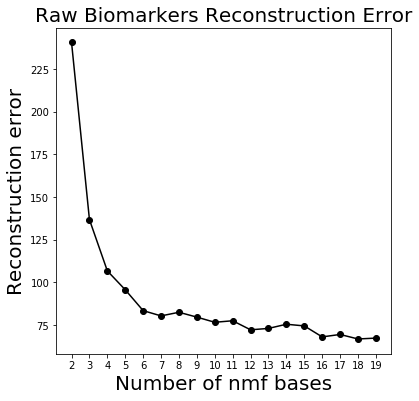

In [63]:
plt.figure(figsize=(6,6))
plt.plot(ks, recon_err, '-o', color='black')
plt.xticks(ks)
plt.xlabel('Number of nmf bases', fontsize=20)
plt.ylabel('Reconstruction error', fontsize=20)
plt.title('Raw Biomarkers Reconstruction Error', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/raw_bm_recon.pdf')

In [13]:
rawdata.outcome_features[np.where(np.min(raw_oc, axis=0) < 0)[0]]

array(['CVLTTrial1StandardScore_6mo', 'CVLTTrial2StandardScore_6mo',
       'CVLTTrial3StandardScore_6mo', 'CVLTTrial4StandardScore_6mo',
       'CVLTTrial5StandardScore_6mo', 'CVLTTrialBStandardScore_6mo',
       'CVLTShortDelayFreeRecallStandardScore_6mo',
       'CVLTShortDelayCuedRecallStandardScore_6mo',
       'CVLTLongDelayFreeRecallStandardScore_6mo',
       'CVLTLongDelayCuedRecallStandardScore_6mo',
       'CVLTFreeRecallIntrusionsStandard_6mo',
       'CVLTCuedRecallIntrusionsStandard_6mo',
       'CVLTTotalIntrusionsStandard_6mo',
       'CVLTTotalRepetitionsStandard_6mo',
       'CVLTTotalRecognitionHitsStandardScore_6mo',
       'CVLTTotalRecognitionDiscriminabilityStandardScore_6mo'],
      dtype='<U53')

In [42]:
# scale outcomes 
scaler = MinMaxScaler()
transformed_raw_oc = scaler.fit_transform(raw_oc)
transformed_raw_oc.shape

(247, 177)

In [47]:
transformed_raw_oc = raw_oc - np.min(raw_oc, axis=0)

In [54]:

ks = list(range(2,20))
recon_oc = np.zeros((len(ks), transformed_raw_oc.shape[0], transformed_raw_oc.shape[1]))

recon_err_oc = np.zeros(len(ks))

for cv, (train_index, test_index) in enumerate(kf.split(transformed_raw_oc, raw_oc[:,32])):
    train, test = transformed_raw_oc[train_index], transformed_raw_oc[test_index]
    train_oc = train
    test_oc = test
    for ii,k in enumerate(ks):
        nmf = NMF(n_components = k, beta_loss='kullback-leibler', solver='mu', max_iter=1000, init='random')
        W_fit = nmf.fit(train_oc)
        transform = nmf.transform(test_oc)
        inv_transform = nmf.inverse_transform(transform)
        recon_oc[ii,test_index] = inv_transform
        
for ii,k in enumerate(ks):
    recon_err_oc[ii] = np.linalg.norm(recon_oc[ii]-transformed_raw_oc)

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


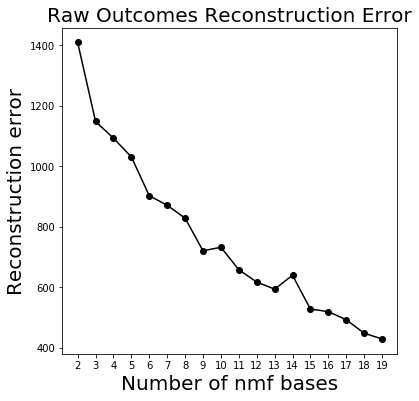

In [55]:
plt.figure(figsize=(6,6))
plt.plot(ks, recon_err_oc, '-o', color='black')
plt.xticks(ks)
plt.xlabel('Number of nmf bases', fontsize=20)
plt.ylabel('Reconstruction error', fontsize=20)
plt.title('Raw Outcomes Reconstruction Error', fontsize=20)
plt.savefig('/Users/ahyeon/Desktop/activ misc/raw_oc_recon.pdf')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Text(0.5, 1.0, 'Raw Outcomes Reconstruction Error')

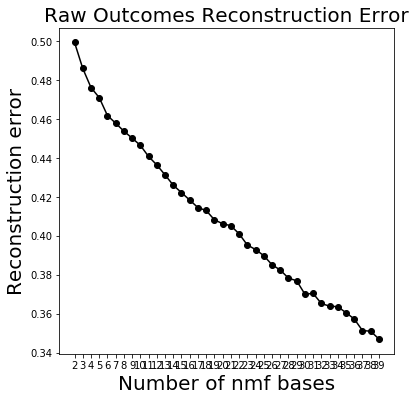

In [59]:
# scale outcomes 
scaler = MinMaxScaler()
transformed_raw_oc = scaler.fit_transform(raw_oc)
transformed_raw_oc.shape

ks = list(range(2,40))
recon_oc = np.zeros((len(ks), transformed_raw_oc.shape[0], transformed_raw_oc.shape[1]))

recon_err_oc = np.zeros(len(ks))

for cv, (train_index, test_index) in enumerate(kf.split(transformed_raw_oc, raw_oc[:,32])):
    train, test = transformed_raw_oc[train_index], transformed_raw_oc[test_index]
    train_oc = train
    test_oc = test
    for ii,k in enumerate(ks):
        nmf = NMF(n_components = k, beta_loss='kullback-leibler', solver='mu', max_iter=1000, init='random')
        W_fit = nmf.fit(train_oc)
        transform = nmf.transform(test_oc)
        inv_transform = nmf.inverse_transform(transform)
        recon_oc[ii,test_index] = inv_transform
        
div = np.linalg.norm(transformed_raw_oc)
for ii,k in enumerate(ks):
    recon_err_oc[ii] = np.linalg.norm(recon_oc[ii]-transformed_raw_oc)/div

plt.figure(figsize=(6,6))
plt.plot(ks, recon_err_oc, '-o', color='black')
plt.xticks(ks)
plt.xlabel('Number of nmf bases', fontsize=20)
plt.ylabel('Reconstruction error', fontsize=20)
plt.title('Raw Outcomes Reconstruction Error', fontsize=20)

In [10]:
# uoinmf on outcomes

transformed_raw_oc = raw_oc - np.min(raw_oc, axis=0)
oc_input = transformed_raw_oc


eps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
minsamples = np.arange(20,80,5)
kf = StratifiedKFold(n_splits=5)

In [11]:
error_mat = np.zeros((len(eps),len(minsamples),5))
k_mat = np.zeros((len(eps), len(minsamples), 5))
for cv, (train_index, test_index) in enumerate(kf.split(oc_input, raw_oc[:,32])):
    train, test = oc_input[train_index], oc_input[test_index]
    train_oc = train
    test_oc = test
    for ii,e in enumerate(eps):
        for jj,m in enumerate(minsamples):
            print('eps {} minsamples {}'.format(e,m))
            db = DBSCAN(eps=e, min_samples=m)
            uoinmf = UoINMF(ranks=list(range(2,20)),dbscan=db)
            decomp = uoinmf.fit(train_oc)
            H = decomp.components_
            W = decomp.transform(test_oc, reconstruction_err=True)
            error = np.linalg.norm(test_oc-W@H)
            error_mat[ii,jj,cv] = error
            k_mat[ii,jj,cv] = H.shape[0]

/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


eps 0.2 minsamples 20
eps 0.2 minsamples 25
eps 0.2 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 35
eps 0.2 minsamples 40
eps 0.2 minsamples 45
eps 0.2 minsamples 50


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 55


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 60
eps 0.2 minsamples 65
eps 0.2 minsamples 70
eps 0.2 minsamples 75


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 20
eps 0.3 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 30
eps 0.3 minsamples 35
eps 0.3 minsamples 40
eps 0.3 minsamples 45


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 50
eps 0.3 minsamples 55
eps 0.3 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 65
eps 0.3 minsamples 70


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 75


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 20
eps 0.4 minsamples 25
eps 0.4 minsamples 30
eps 0.4 minsamples 35
eps 0.4 minsamples 40
eps 0.4 minsamples 45
eps 0.4 minsamples 50
eps 0.4 minsamples 55
eps 0.4 minsamples 60
eps 0.4 minsamples 65
eps 0.4 minsamples 70
eps 0.4 minsamples 75
eps 0.5 minsamples 20


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.5 minsamples 25
eps 0.5 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.5 minsamples 35
eps 0.5 minsamples 40
eps 0.5 minsamples 45
eps 0.5 minsamples 50
eps 0.5 minsamples 55
eps 0.5 minsamples 60
eps 0.5 minsamples 65
eps 0.5 minsamples 70
eps 0.5 minsamples 75
eps 0.6 minsamples 20
eps 0.6 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 30
eps 0.6 minsamples 35
eps 0.6 minsamples 40
eps 0.6 minsamples 45
eps 0.6 minsamples 50
eps 0.6 minsamples 55
eps 0.6 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 65
eps 0.6 minsamples 70
eps 0.6 minsamples 75
eps 0.7 minsamples 20
eps 0.7 minsamples 25
eps 0.7 minsamples 30
eps 0.7 minsamples 35
eps 0.7 minsamples 40
eps 0.7 minsamples 45
eps 0.7 minsamples 50
eps 0.7 minsamples 55


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 60
eps 0.7 minsamples 65
eps 0.7 minsamples 70
eps 0.7 minsamples 75


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 20


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 30
eps 0.8 minsamples 35
eps 0.8 minsamples 40
eps 0.8 minsamples 45
eps 0.8 minsamples 50
eps 0.8 minsamples 55
eps 0.8 minsamples 60
eps 0.8 minsamples 65
eps 0.8 minsamples 70
eps 0.8 minsamples 75


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 20
eps 0.2 minsamples 25
eps 0.2 minsamples 30
eps 0.2 minsamples 35
eps 0.2 minsamples 40
eps 0.2 minsamples 45
eps 0.2 minsamples 50
eps 0.2 minsamples 55
eps 0.2 minsamples 60
eps 0.2 minsamples 65
eps 0.2 minsamples 70
eps 0.2 minsamples 75
eps 0.3 minsamples 20
eps 0.3 minsamples 25
eps 0.3 minsamples 30
eps 0.3 minsamples 35
eps 0.3 minsamples 40
eps 0.3 minsamples 45
eps 0.3 minsamples 50
eps 0.3 minsamples 55
eps 0.3 minsamples 60
eps 0.3 minsamples 65


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 70
eps 0.3 minsamples 75
eps 0.4 minsamples 20
eps 0.4 minsamples 25
eps 0.4 minsamples 30
eps 0.4 minsamples 35
eps 0.4 minsamples 40
eps 0.4 minsamples 45
eps 0.4 minsamples 50
eps 0.4 minsamples 55
eps 0.4 minsamples 60
eps 0.4 minsamples 65
eps 0.4 minsamples 70


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 75
eps 0.5 minsamples 20
eps 0.5 minsamples 25
eps 0.5 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.5 minsamples 35
eps 0.5 minsamples 40
eps 0.5 minsamples 45
eps 0.5 minsamples 50
eps 0.5 minsamples 55
eps 0.5 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.5 minsamples 65
eps 0.5 minsamples 70
eps 0.5 minsamples 75
eps 0.6 minsamples 20
eps 0.6 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 30
eps 0.6 minsamples 35


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 40
eps 0.6 minsamples 45
eps 0.6 minsamples 50
eps 0.6 minsamples 55
eps 0.6 minsamples 60
eps 0.6 minsamples 65
eps 0.6 minsamples 70
eps 0.6 minsamples 75
eps 0.7 minsamples 20
eps 0.7 minsamples 25
eps 0.7 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 35
eps 0.7 minsamples 40


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 45
eps 0.7 minsamples 50
eps 0.7 minsamples 55
eps 0.7 minsamples 60
eps 0.7 minsamples 65
eps 0.7 minsamples 70
eps 0.7 minsamples 75
eps 0.8 minsamples 20
eps 0.8 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 30
eps 0.8 minsamples 35
eps 0.8 minsamples 40
eps 0.8 minsamples 45
eps 0.8 minsamples 50
eps 0.8 minsamples 55
eps 0.8 minsamples 60
eps 0.8 minsamples 65


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 70
eps 0.8 minsamples 75
eps 0.2 minsamples 20
eps 0.2 minsamples 25
eps 0.2 minsamples 30
eps 0.2 minsamples 35
eps 0.2 minsamples 40
eps 0.2 minsamples 45
eps 0.2 minsamples 50
eps 0.2 minsamples 55
eps 0.2 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 65


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 70


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 75
eps 0.3 minsamples 20
eps 0.3 minsamples 25
eps 0.3 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 35
eps 0.3 minsamples 40


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 45
eps 0.3 minsamples 50


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 55


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 60
eps 0.3 minsamples 65
eps 0.3 minsamples 70
eps 0.3 minsamples 75
eps 0.4 minsamples 20
eps 0.4 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 30
eps 0.4 minsamples 35
eps 0.4 minsamples 40
eps 0.4 minsamples 45
eps 0.4 minsamples 50


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 55
eps 0.4 minsamples 60
eps 0.4 minsamples 65
eps 0.4 minsamples 70
eps 0.4 minsamples 75


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.5 minsamples 20
eps 0.5 minsamples 25
eps 0.5 minsamples 30
eps 0.5 minsamples 35
eps 0.5 minsamples 40
eps 0.5 minsamples 45
eps 0.5 minsamples 50
eps 0.5 minsamples 55
eps 0.5 minsamples 60
eps 0.5 minsamples 65
eps 0.5 minsamples 70
eps 0.5 minsamples 75
eps 0.6 minsamples 20
eps 0.6 minsamples 25
eps 0.6 minsamples 30
eps 0.6 minsamples 35
eps 0.6 minsamples 40
eps 0.6 minsamples 45
eps 0.6 minsamples 50
eps 0.6 minsamples 55
eps 0.6 minsamples 60
eps 0.6 minsamples 65
eps 0.6 minsamples 70
eps 0.6 minsamples 75
eps 0.7 minsamples 20
eps 0.7 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 30
eps 0.7 minsamples 35
eps 0.7 minsamples 40
eps 0.7 minsamples 45
eps 0.7 minsamples 50
eps 0.7 minsamples 55
eps 0.7 minsamples 60
eps 0.7 minsamples 65
eps 0.7 minsamples 70
eps 0.7 minsamples 75
eps 0.8 minsamples 20
eps 0.8 minsamples 25
eps 0.8 minsamples 30
eps 0.8 minsamples 35
eps 0.8 minsamples 40
eps 0.8 minsamples 45
eps 0.8 minsamples 50
eps 0.8 minsamples 55
eps 0.8 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 65
eps 0.8 minsamples 70
eps 0.8 minsamples 75
eps 0.2 minsamples 20
eps 0.2 minsamples 25
eps 0.2 minsamples 30
eps 0.2 minsamples 35
eps 0.2 minsamples 40
eps 0.2 minsamples 45
eps 0.2 minsamples 50
eps 0.2 minsamples 55
eps 0.2 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 65
eps 0.2 minsamples 70
eps 0.2 minsamples 75
eps 0.3 minsamples 20
eps 0.3 minsamples 25
eps 0.3 minsamples 30
eps 0.3 minsamples 35
eps 0.3 minsamples 40
eps 0.3 minsamples 45
eps 0.3 minsamples 50
eps 0.3 minsamples 55
eps 0.3 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 65
eps 0.3 minsamples 70
eps 0.3 minsamples 75
eps 0.4 minsamples 20
eps 0.4 minsamples 25
eps 0.4 minsamples 30
eps 0.4 minsamples 35
eps 0.4 minsamples 40
eps 0.4 minsamples 45
eps 0.4 minsamples 50


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 55


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.4 minsamples 65
eps 0.4 minsamples 70
eps 0.4 minsamples 75
eps 0.5 minsamples 20
eps 0.5 minsamples 25
eps 0.5 minsamples 30
eps 0.5 minsamples 35
eps 0.5 minsamples 40
eps 0.5 minsamples 45
eps 0.5 minsamples 50
eps 0.5 minsamples 55
eps 0.5 minsamples 60
eps 0.5 minsamples 65
eps 0.5 minsamples 70
eps 0.5 minsamples 75
eps 0.6 minsamples 20
eps 0.6 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macos

eps 0.6 minsamples 35
eps 0.6 minsamples 40
eps 0.6 minsamples 45
eps 0.6 minsamples 50


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 55
eps 0.6 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 65
eps 0.6 minsamples 70
eps 0.6 minsamples 75
eps 0.7 minsamples 20
eps 0.7 minsamples 25
eps 0.7 minsamples 30
eps 0.7 minsamples 35


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 40
eps 0.7 minsamples 45
eps 0.7 minsamples 50
eps 0.7 minsamples 55
eps 0.7 minsamples 60


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 65
eps 0.7 minsamples 70
eps 0.7 minsamples 75
eps 0.8 minsamples 20
eps 0.8 minsamples 25
eps 0.8 minsamples 30
eps 0.8 minsamples 35
eps 0.8 minsamples 40


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 45
eps 0.8 minsamples 50
eps 0.8 minsamples 55


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 60
eps 0.8 minsamples 65
eps 0.8 minsamples 70
eps 0.8 minsamples 75
eps 0.2 minsamples 20
eps 0.2 minsamples 25
eps 0.2 minsamples 30
eps 0.2 minsamples 35
eps 0.2 minsamples 40
eps 0.2 minsamples 45
eps 0.2 minsamples 50
eps 0.2 minsamples 55
eps 0.2 minsamples 60
eps 0.2 minsamples 65


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.2 minsamples 70
eps 0.2 minsamples 75
eps 0.3 minsamples 20
eps 0.3 minsamples 25
eps 0.3 minsamples 30


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 35


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 40


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 45
eps 0.3 minsamples 50
eps 0.3 minsamples 55


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 60
eps 0.3 minsamples 65


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 70


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.3 minsamples 75
eps 0.4 minsamples 20
eps 0.4 minsamples 25
eps 0.4 minsamples 30
eps 0.4 minsamples 35
eps 0.4 minsamples 40
eps 0.4 minsamples 45
eps 0.4 minsamples 50
eps 0.4 minsamples 55
eps 0.4 minsamples 60
eps 0.4 minsamples 65
eps 0.4 minsamples 70
eps 0.4 minsamples 75
eps 0.5 minsamples 20
eps 0.5 minsamples 25
eps 0.5 minsamples 30
eps 0.5 minsamples 35
eps 0.5 minsamples 40
eps 0.5 minsamples 45
eps 0.5 minsamples 50
eps 0.5 minsamples 55
eps 0.5 minsamples 60
eps 0.5 minsamples 65
eps 0.5 minsamples 70
eps 0.5 minsamples 75
eps 0.6 minsamples 20
eps 0.6 minsamples 25


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.6 minsamples 30
eps 0.6 minsamples 35
eps 0.6 minsamples 40
eps 0.6 minsamples 45
eps 0.6 minsamples 50
eps 0.6 minsamples 55
eps 0.6 minsamples 60
eps 0.6 minsamples 65
eps 0.6 minsamples 70
eps 0.6 minsamples 75
eps 0.7 minsamples 20
eps 0.7 minsamples 25
eps 0.7 minsamples 30
eps 0.7 minsamples 35
eps 0.7 minsamples 40
eps 0.7 minsamples 45
eps 0.7 minsamples 50
eps 0.7 minsamples 55
eps 0.7 minsamples 60
eps 0.7 minsamples 65
eps 0.7 minsamples 70


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.7 minsamples 75
eps 0.8 minsamples 20


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 25
eps 0.8 minsamples 30
eps 0.8 minsamples 35
eps 0.8 minsamples 40
eps 0.8 minsamples 45


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


eps 0.8 minsamples 50
eps 0.8 minsamples 55
eps 0.8 minsamples 60
eps 0.8 minsamples 65
eps 0.8 minsamples 70
eps 0.8 minsamples 75


/Users/ahyeon/anaconda3/envs/activ/lib/python3.7/site-packages/scikit_learn-0.20.2-py3.7-macosx-10.7-x86_64.egg/sklearn/decomposition/nmf.py:1050: ConvergenceWarning: Maximum number of iteration 400 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [12]:
f = h5py.File('/Users/ahyeon/data/activ/uoinmf_oc_rec.h5', 'w')

In [13]:
f.create_dataset('error_mat', data=error_mat)
f.create_dataset('k_mat', data=k_mat)

<HDF5 dataset "k_mat": shape (7, 12, 5), type "<f8">

In [15]:
len(eps), len(minsamples)

(7, 12)

In [20]:
error_mat_avg = np.mean(error_mat, axis=2)

In [34]:
k_mat_avg = np.mean(k_mat, axis=2)

(<matplotlib.image.AxesImage at 0x126c372b0>,
 <matplotlib.colorbar.Colorbar at 0x126fc9ba8>)

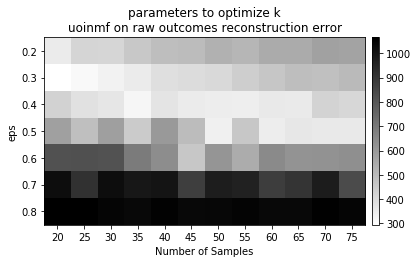

In [33]:
from activ.analytics import heatmap
heatmap(error_mat_avg, eps, minsamples, xlab='Number of Samples', ylab='eps', 
        title='parameters to optimize k\nuoinmf on raw outcomes reconstruction error')


In [40]:
# index of lowest reconstruction error 

np.unravel_index(np.argmin(error_mat_avg, axis=None), error_mat_avg.shape)

(1, 0)

(<matplotlib.image.AxesImage at 0x127044518>,
 <matplotlib.colorbar.Colorbar at 0x12706ae10>)

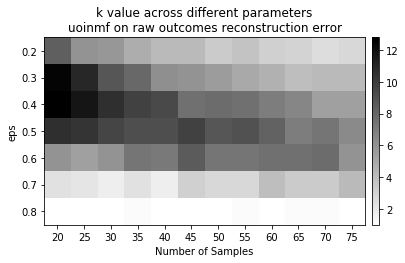

In [35]:
heatmap(k_mat_avg, eps, minsamples, xlab='Number of Samples', ylab='eps', 
        title='k value across different parameters\nuoinmf on raw outcomes reconstruction error')

In [41]:
# avg k value for lowest reconstruction error

k_mat_avg[1,0]

12.6

In [43]:
k_mat[1,0]

array([ 9., 12., 14., 13., 15.])

In [44]:
k_mat_avg[3,6]

8.8